In [190]:
import os
import csv
import paramiko
import gzip

import pymysql
from sshtunnel import SSHTunnelForwarder

from tqdm import tqdm

from datetime import timedelta
from datetime import date
from datetime import datetime

import pandas as pd
from collections import defaultdict

import numpy as np

import matplotlib.dates as mdates

import re

In [114]:
%matplotlib inline

plt.rcParams['font.family'] = 'Arial'

In [115]:
database = "clinical_merge_v5_2020q4"
ped_data = "/home/kel2158/Projects/Heritability_Base_Data/pedigree_v3_updated_results/"
output_folder = "/home/kel2158/Projects/COVIDHerit/data/12_29_21/"
hhid_folder = "/home/kel2158/Projects/hhid_update/data/"

demo_file = os.path.join(output_folder, "demo.txt.gz")
hosp_days_file = os.path.join(output_folder, "days_hosp.txt.gz")
covid_nopro_file = os.path.join(output_folder, "covid_noproband.txt.gz")
covid_file = os.path.join(output_folder, "covid.txt.gz")

hosp_stat_file = os.path.join(output_folder, "hosp_stat.txt.gz")
hosp_stat_nopro_file = os.path.join(output_folder, "hosp_stat_noproband.txt.gz")
high_deg_file = os.path.join(output_folder, "covid_high_degfam.txt.gz")
high_deg_nopro_file = os.path.join(output_folder, "covid_high_degfam_noproband.txt.gz")

time2pcr_file = os.path.join(output_folder, "time2firstpcr.txt.gz")

cummulative_directory = os.path.join(output_folder, "cummulative_classswitch")

# Input files
finename_fam_input = os.path.join(ped_data, "family_v3.txt.gz")
filename_hhid = os.path.join(hhid_folder, "hhid_trimmed_notcln.txt.gz")
buildid_file = os.path.join(hhid_folder, "buildid_notcln.txt.gz")
filename_ped_input = os.path.join(ped_data, "pedigree_v3.txt.gz")


#Figure output directory
figure_directory = '/home/kel2158/Projects/COVIDHerit/figures'

In [120]:
def return_sign_in(login_loc = '/home/kel2158/login.txt'):
    login_dict = dict()
    with open(login_loc, "r") as file:
        for line in file.readlines():
            login_dict[ line.split(",")[0]] = line.split(",")[1].strip()
    return(login_dict)

In [121]:
login_dict = return_sign_in()

ssh = paramiko.SSHClient()
ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
ssh.connect('10.144.220.21', username=login_dict['user'], password=login_dict['mimir_pw'])


In [122]:
server = SSHTunnelForwarder(
    '10.144.220.21',
    ssh_username='kel2158',
    ssh_password=login_dict['mimir_pw'],
    remote_bind_address=('127.0.0.1', 3306)
)
server.start()

db = pymysql.connect(
    host='127.0.0.1',
    port=server.local_bind_port,
    user=login_dict['user'],
    password=login_dict["db_pw"],
    db=database
)

cur = db.cursor()



## Pull Data

In [123]:
#Read in time to first pcr trait file 
file_name = filename_ped_input
gfile = gzip.open(file_name)
ped_df = pd.read_csv(gfile,sep='\t')
gfile.close()



In [124]:
#Read in demo df
file_name = demo_file
gfile = gzip.open(file_name)
demo_df = pd.read_csv(gfile,sep='\t')
gfile.close()



In [125]:
#Read in family and id dataframe
file_name = finename_fam_input
gfile = gzip.open(file_name)
fam_df = pd.read_csv(gfile,sep='\t')
gfile.close()


In [126]:
#Read in HHID file 
file_name = filename_hhid
gfile = gzip.open(file_name)
hhid_df = pd.read_csv(gfile,sep='\t')
gfile.close()


mrn2hhid = dict(zip( hhid_df["mrn"], hhid_df["trimmed_hhid"] ))

In [127]:
#Read in BuildingID file 
file_name = buildid_file
gfile = gzip.open(file_name)
bid_df = pd.read_csv(gfile,sep='\t')
gfile.close()


mrn2bid = dict(zip( bid_df["mrn"], bid_df["building_id"] ))

In [128]:
#Read in time to first pcr trait file 
file_name = time2pcr_file
gfile = gzip.open(file_name)
time2pcr_df = pd.read_csv(gfile,sep='\t')
gfile.close()


In [129]:
#Read in covid susceptibility file
file_name = covid_file
gfile = gzip.open(file_name)
cov_df = pd.read_csv(gfile,sep='\t')
gfile.close()

In [130]:
#Read in cov noproband
file_name = covid_nopro_file
gfile = gzip.open(file_name)
covnopro_df = pd.read_csv(gfile,sep='\t')
gfile.close()


In [131]:
#Read in days_hosp
file_name = hosp_days_file
gfile = gzip.open(file_name)
hospday_df = pd.read_csv(gfile,sep='\t')

gfile.close()


In [132]:
#Read in hospitalization_stat
file_name = hosp_stat_file
gfile = gzip.open(file_name)
hosp_df = pd.read_csv(gfile,sep='\t')

gfile.close()


In [133]:
#Read in hospitalization_stat_noproband
file_name = hosp_stat_nopro_file
gfile = gzip.open(file_name)
hosp_nopro_df = pd.read_csv(gfile,sep='\t')

gfile.close()


In [134]:
#Read in high_deg
file_name = high_deg_file
gfile = gzip.open(file_name)
high_deg_df = pd.read_csv(gfile,sep='\t')

gfile.close()


In [135]:
#Read in high_deg_noproband
file_name = high_deg_nopro_file
gfile = gzip.open(file_name)
high_deg_nopro_df = pd.read_csv(gfile,sep='\t')

gfile.close()


In [136]:
pull_data_query = """SELECT *
FROM clinical_relationships_v3.all_relationships_to_generate_pedigree_file"""


cur.execute(pull_data_query)
rawdata = cur.fetchall()

rel_df = pd.DataFrame(list(rawdata),
                    columns=["mrn","relationship","relation_mrn","provided_relationship",
                             ])

In [137]:
pull_data_query = """SELECT *
FROM clinical_relationships.relationships_degree"""


cur.execute(pull_data_query)
rawdata = cur.fetchall()

reldegree_df = pd.DataFrame(list(rawdata),
                    columns=["relationship","degree"
                             ])

rel2degree = dict( zip( reldegree_df["relationship"],reldegree_df["degree"] ) ) 

In [138]:
db.close()
server.stop() 

## Functions

In [139]:
# Initialize a list to keep track of all figures
all_figures = []

# Create a function to save a figure and add it to the list
def save_and_track_figure(fig, filename, save_directory = figure_directory):
    # Combine the save_directory and filename to create the full path
    save_path = os.path.join(save_directory, filename)
    
    fig.patch.set_facecolor('white')
    # Save the figure with the full path
    fig.savefig(save_path, dpi=300, bbox_inches="tight")
    
    # Append the saved file path to the list of saved figures
    all_figures.append(save_path)



In [140]:
def pull_fam_count( pheno, df, print_res = True, \
                   return_fams_df=False, type_pheno="binary_withproband",
                   return_patient_limited_df = False ):
    
    """Returns the number of families in a phenotype for SOLAR based on pheno 
     Needs phenotype column, famid column and ptid column"""    
    
    #subset on phenotype of interest and those in our pedigree
    df_phenosub = df[ (df["pheno"] == pheno ) 
                       &  (~df["famid"].isnull())] 
    
    #Get the total number of  members in each fam and then number of cases
    df_phenogrouped = df_phenosub.groupby( 'famid' )\
        .agg({ "ptid":"count","value":sum })\
        .reset_index()\
        .rename(columns={ "ptid":"num_fam_members","value":"num_cases" })
    
    #Subset to fams that will be included in SOLAR
    #ie has more than one family member an at least one case in each family
    if type_pheno == "binary_withproband":
        solar_fams_df = df_phenogrouped[ (df_phenogrouped["num_fam_members"] > 1) \
                                        & (df_phenogrouped["num_cases"] > 0) ]
    
    else:
         solar_fams_df = df_phenogrouped[ (df_phenogrouped["num_fam_members"] > 1)]
    
    solar_limited_df = df_phenosub[ df_phenosub["famid"].isin(solar_fams_df["famid"].unique())]
    solar_limited_df.drop_duplicates(inplace=True)
    solar_patients = set( solar_limited_df["ptid"] )
    
    
    
    if print_res:
            print(f'There are {len(solar_fams_df)} SOLAR families')
    
    if return_fams_df:
        return solar_fams_df, solar_patients
    
    elif return_patient_limited_df:
        return solar_limited_df
    
    else:
        return(len( solar_fams_df) )
    

## Process Data

In [141]:
#Map for differences in how SOLAR includes people
#Options: binary_withproband OR quant_or_binary_noproband
pheno2type = {   
"covid":"binary_withproband",
"covid_noproband":"binary_noproband",
"days_hosp":"quant",
    "hosp_stat":"binary_withproband",
    "hosp_stat_nopro":"binary_noproband",
    "covid_highdeg_fam":"binary_withproband",
    "covid_highdeg_nopro":"binary_noproband",
}



In [142]:
#Info for mapping
mrn2sex = dict(zip( demo_df["ptid"],demo_df["sex"] ))
mrn2famid = dict(zip( fam_df["ptid"],fam_df["famid"] ))

#Map famid to demo df
demo_df["famid"]  = demo_df["ptid"].map(mrn2famid)

pheno_dfs = [cov_df, covnopro_df, 
             hospday_df,hosp_df,hosp_nopro_df,
             high_deg_df,high_deg_nopro_df]


In [143]:
def merge_limit2solar(df, pheno):
    #Merge with demo data
    df = df.merge(demo_df, how="left", left_on="ptid", right_on="ptid") 
    
    #Get patients included in solar runs
    df = pull_fam_count(pheno, df,
                                type_pheno=pheno2type[pheno],
                                return_patient_limited_df=True)
    return df



In [144]:
#Map demo and limit to SOLAR patients
covnopro_limited_df = merge_limit2solar(covnopro_df,"covid_noproband")
cov_limited_df = merge_limit2solar(cov_df,"covid")
hospday_limited_df = merge_limit2solar(hospday_df,"days_hosp")

hosp_limited_df = merge_limit2solar(hosp_df,"hosp_stat")
hosp_nopro_limited_df = merge_limit2solar(hosp_nopro_df,"hosp_stat_nopro")
highdeg_limited_df = merge_limit2solar(high_deg_df,"covid_highdeg_fam")
highdeg_nopro_limited_df = merge_limit2solar(high_deg_nopro_df,"covid_highdeg_nopro")


df_limited = [covnopro_limited_df,cov_limited_df,hospday_limited_df ,
             hosp_limited_df,hosp_nopro_limited_df,highdeg_limited_df,highdeg_nopro_limited_df]

There are 5676 SOLAR families
There are 1324 SOLAR families
There are 158 SOLAR families
There are 115 SOLAR families
There are 158 SOLAR families
There are 296 SOLAR families
There are 962 SOLAR families


In [145]:
len( covnopro_limited_df["ptid"].unique() )

12764

In [146]:
covnopro_limited_rel_df = covnopro_limited_df.copy()
covnopro_limited_rel_df["ptid"] = covnopro_limited_rel_df["ptid"].astype(str)

#Merge relationship and pheno and limit to solar families AND both sides of relationship must
#have covid tests so limit rel file where relation_mrn is in pheno_df also
rel_limit_df = covnopro_limited_rel_df.merge( rel_df[ rel_df["relation_mrn"].isin( covnopro_limited_rel_df["ptid"] ) ]
                                         , how='inner', left_on='ptid', right_on='mrn')
 
#Map the degree of relationship    
rel_limit_df["rel_degree"] = rel_limit_df["relationship"].map(rel2degree)

## Check Ethnicity

In [147]:
#Dictionary to map ethnicity to SOLARStrap friendly coding
map_ethnic_dict = { "NOT HISPANIC OR LATINO OR SPANISH ORIGIN":'U',
"DECLINED":'U',
"HISPANIC OR LATINO OR SPANISH ORIGIN":'H',
"AFRICAN AMERICAN":'B',
"MULTI-RACIAL":"Other",
"UNKNOWN":"U",
"CAUCASIAN":"W",
None:"U",
"(null)":'U',
"ASIAN / PACIFIC ISLANDER":"Other",
"AMERICAN INDIAN / ESKIMO":"Other"
                  }

map_race_dict = {'WHITE':'W'
                    , 'BLACK OR AFRICAN AMERICAN':'B'
                    , 'ASIAN':'Other'
                    ,'OTHER COMBINATIONS NOT DESCRIBED':'Other'
                   ,'AMERICAN INDIAN OR ALASKA NATION':'Other'
                   ,'NAT.HAWAIIAN/OTH.PACIFIC ISLAND':'Other'
                    ,'SEPHARDIC JEWISH':'Other'
                       ,'ASHKENAZI JEWISH':'Other'
                    ,'NULL':'NA'
                  , '(null)':'NA'
                  , 'DECLINED':'NA'
              }


In [148]:
#Solar implementation on combining race and ethnicity
def fe_ethnicity_race(mrn, race, ethnicity):
    if race in ('NA','U', 'D'):
        if ethnicity == 'W':
            race = 'White'
        elif ethnicity == 'B':
            race = 'Black'
        elif ethnicity in ('H', 'S', 'O'):
            race = 'Hispanic'
        elif ethnicity in ('NULL', '', 'U', 'D', '2'):
            race = 'Unknown'
        else:
            race = 'Other'
    else:
        if race == 'W':
            if ethnicity == 'H':
                race = 'Hispanic'
            else:
                race = 'White'
        elif race == 'B':
            if ethnicity == 'H':
                race = 'Hispanic'
            else:
                race = 'Black'
        elif race == 'O':
            race = 'Hispanic'
        else:
            race = 'Other'
    
    empi2race_eth[mrn] = race
#    mrn2race_fe[race][mrn] = 1

In [149]:
covnopro_limited_rel_df["ethnicity_mapped"] = covnopro_limited_rel_df["ethnic_code"].map(map_ethnic_dict).fillna(covnopro_limited_rel_df["ethnic_code"])
covnopro_limited_rel_df["race_mapped"] = covnopro_limited_rel_df["race_code"].map(map_race_dict).fillna(covnopro_limited_rel_df["race_code"])

In [150]:
empi2race_eth = defaultdict(dict)

for row in covnopro_limited_rel_df.iterrows():
    
    mrn = str(row[1]["ptid"])
    race = row[1]["race_mapped"]
    ethnicity = row[1]["ethnicity_mapped"]
    
    fe_ethnicity_race(mrn, race, ethnicity)

In [151]:
def assign_family_ethnicities(fam2empi, empi2demog, print_breakdown=True):
    """
    Assign each family a single ethnicity. This makes the (incorrect) assumption that everyone in the same
    family will have the same ethnicity. However, because there are so much missing data, this is better
    than nothing at all.

    fam2empi        dict, map from family id to a set of patients identifiers that belong in that family
    empi2demog      dict, map from patient identifiers to the demographic data (including self-reported race/ethnicity data)
    """

    print("Identifying most commonly reported ethnicity for each family...")

    eth2fam = defaultdict(set)
    fam2eth = dict()
   
    for fid, members in tqdm(fam2empi.items()):
        

        family_ethnicities = [empi2race_eth[e] for e in members if empi2race_eth.get(e,0) != 0 if empi2race_eth[e] != 'Unknown' ]
        if len(family_ethnicities) == 0:
            mode = 'Unknown'
        else:
            mode = max(set(family_ethnicities), key=family_ethnicities.count)

        eth2fam[mode].add(fid)
        fam2eth[fid] = mode

    if print_breakdown:
        for eth, families in eth2fam.items():
            print( "\t%s: %d" % (eth, len(families)))

    return eth2fam, fam2eth


In [152]:
#map family to patient ID
fam2empi = defaultdict(list)

for row in tqdm( fam_df[ fam_df["ptid"].isin(covnopro_limited_rel_df["ptid"].astype(int)) ]\
                .iterrows() ):
    fam2empi[row[1]["famid"]].append(row[1]["ptid"].astype(str))

12764it [00:01, 9098.18it/s]


In [153]:
eth2fam, fam2eth = assign_family_ethnicities(fam2empi,empi2race_eth)

Identifying most commonly reported ethnicity for each family...


100%|████████████████████████████████████| 5676/5676 [00:00<00:00, 47960.30it/s]


	White: 1197
	Black: 718
	Other: 2050
	Hispanic: 1711


In [154]:
covnopro_limited_rel_df["fam_race_eth"] = covnopro_limited_rel_df["famid"].map(fam2eth)
covnopro_limited_rel_df["fe_race_eth"] = covnopro_limited_rel_df["ptid"].astype(str).map(empi2race_eth)

In [155]:
holder_list = []
holder_list_cols = ["pheno", "nfemale", "nnonfemales", "nfemale_cases", "nnon_female_cases",
                    "percent_cases_female", "percent_cases_nonfemale",
                    "percent_controls_female", "percent_controls_nonfemale",
                    "percent_female_cases", "percent_nonfemale_cases",
                    "percent_cases_overall", "variance"]
sample_dict = dict()

for df in df_limited:
    pheno = df["pheno"].unique()[0]
    print(pheno)

    type_pheno = pheno2type[pheno]
    
    sample_dict[pheno] = dict()

    
    if type_pheno == "quant":
        count_df = df.groupby(["sex"], dropna=False).count().reset_index()
        total_f = count_df[count_df["sex"] == "F"]["ptid"].sum()
        total_nf = count_df[count_df["sex"] != "F"]["ptid"].sum()

        f_cases = nf_cases = None
        f_controls = nf_controls=None
        
        percent_controls_overall = None
        percent_cases_overall = None
        

        
    else:
        count_df = df.groupby(["sex", "value"], dropna=False).count().reset_index()
        total_f = count_df[count_df["sex"] == "F"]["ptid"].sum()
        total_nf = count_df[count_df["sex"] != "F"]["ptid"].sum()

        f_cases = count_df[(count_df["sex"] == "F") & (count_df["value"] == 1)]["ptid"].sum()
        nf_cases = count_df[(count_df["sex"] != "F") & (count_df["value"] == 1)]["ptid"].sum()
        percent_cases_overall = round((f_cases + nf_cases) / (total_f + total_nf) * 100)

        f_controls = count_df[(count_df["sex"] == "F") & (count_df["value"] == 0)]["ptid"].sum()
        nf_controls = count_df[(count_df["sex"] != "F") & (count_df["value"] == 0)]["ptid"].sum()
        percent_controls_overall = round((f_controls + nf_controls) / (total_f + total_nf) * 100)



    percent_f = total_f / (total_f + total_nf)
    percent_nf = total_nf / (total_f + total_nf)
    percent_cases_f = round(f_cases / (f_cases + nf_cases) * 100,2) if f_cases is not None else None
    percent_cases_nf = round(nf_cases / (f_cases + nf_cases) * 100,2) if nf_cases is not None else None
    percent_f_cases = round(f_cases / total_f * 100,2) if f_cases is not None else None
    percent_nf_cases = round(nf_cases / total_nf * 100,2) if nf_cases is not None else None

    percent_controls_f = round(f_controls / (f_controls + nf_controls) * 100,2) if f_cases is not None else None
    percent_controls_nf = round(nf_controls / (f_controls + nf_controls) * 100,2) if nf_cases is not None else None
    percent_f_controls = round(f_controls / total_f * 100,2) if f_controls is not None else None
    percent_nf_controls = round(nf_controls / total_nf * 100,2) if nf_cases is not None else None
    
    count_cases = f_cases + nf_cases if f_cases is not None else None
    count_controls = f_controls + nf_controls if f_controls is not None else None
    
    x_variance = np.var(df["value"])


    sample_dict[pheno]["Total Patients"] = count_df
    sample_dict[pheno]["n Cases"] = count_cases
    sample_dict[pheno]["n Controls"] = count_controls
    sample_dict[pheno]["n Female"] = total_f
    sample_dict[pheno]["n Not Female"] = total_nf
    sample_dict[pheno]["Percent Female"] = percent_f
    sample_dict[pheno]["Percent Non-female"] = percent_nf
    
    sample_dict[pheno]["Female Cases"] = f_cases
    sample_dict[pheno]["Non-female Cases"] = nf_cases
    sample_dict[pheno]["Female Controls"] = f_controls
    sample_dict[pheno]["Non-female Controls"] = nf_controls
    sample_dict[pheno]["Percent Cases"] = percent_cases_overall
    sample_dict[pheno]["Percent Controls"] = percent_controls_overall
    sample_dict[pheno]["Percent Cases (Female)"] = percent_cases_f
    sample_dict[pheno]["Percent Cases (Non-female)"] = percent_cases_nf
    sample_dict[pheno]["Percent Controls (Female)"] = percent_controls_f
    sample_dict[pheno]["Percent Controls (Non-female)"] = percent_controls_nf
    sample_dict[pheno]["Percent Female That Are Cases"] = percent_f_cases
    sample_dict[pheno]["Percent Female That Are Controls"] = percent_f_controls
    sample_dict[pheno]["Percent Non-female That Are Cases"] = percent_nf_cases
    sample_dict[pheno]["Percent Non-female That Are Controls"] = percent_nf_controls

samp_df = pd.DataFrame(sample_dict).transpose()

covid_noproband
covid
days_hosp
hosp_stat
hosp_stat_nopro
covid_highdeg_fam
covid_highdeg_nopro


In [156]:
# set the max_columns option to 40
pd.set_option('display.max_columns', 40)

In [157]:
samp_df

,Total Patients,n Cases,n Controls,n Female,n Not Female,Percent Female,Percent Non-female,Female Cases,Non-female Cases,Female Controls,Non-female Controls,Percent Cases,Percent Controls,Percent Cases (Female),Percent Cases (Non-female),Percent Controls (Female),Percent Controls (Non-female),Percent Female That Are Cases,Percent Female That Are Controls,Percent Non-female That Are Cases,Percent Non-female That Are Controls
covid_noproband,sex value ptid pheno birth_decade race...,1580,11184,8554,4210,0.670166,0.329834,1091,489,7463,3721,12,88,69.05,30.95,66.73,33.27,12.75,87.25,11.62,88.38
covid,sex value ptid pheno birth_decade race...,1580,1594,2133,1041,0.672023,0.327977,1091,489,1042,552,50,50,69.05,30.95,65.37,34.63,51.15,48.85,46.97,53.03
days_hosp,sex ptid pheno value birth_decade race_...,None,None,214,122,0.636905,0.363095,None,None,None,None,None,None,None,None,None,None,None,None,None,None
hosp_stat,sex value ptid pheno birth_decade race_...,196,49,158,87,0.644898,0.355102,126,70,32,17,80,20,64.29,35.71,65.31,34.69,79.75,20.25,80.46,19.54
hosp_stat_nopro,sex value ptid pheno birth_decade race_...,196,140,214,122,0.636905,0.363095,126,70,88,52,58,42,64.29,35.71,62.86,37.14,58.88,41.12,57.38,42.62
covid_highdeg_fam,sex value ptid pheno birth_decade race_...,369,558,624,303,0.673139,0.326861,257,112,367,191,40,60,69.65,30.35,65.77,34.23,41.19,58.81,36.96,63.04
covid_highdeg_nopro,sex value ptid pheno birth_decade race_...,369,2332,1832,869,0.678267,0.321733,257,112,1575,757,14,86,69.65,30.35,67.54,32.46,14.03,85.97,12.89,87.11


In [158]:
#Get race/ethnicity data broken out by case and control status
total = len( covnopro_limited_rel_df )

race_eth_df = covnopro_limited_rel_df.groupby(["fe_race_eth","value"],dropna=False ).count()\
["ptid"].reset_index()

race_eth_df.rename(columns={"ptid":"n"},inplace=True)

race_eth_df["percent_race_eth"] = round( (race_eth_df["n"]/total)*100, 2)

In [159]:
race_eth_df

,fe_race_eth,value,n,percent_race_eth
0,Black,0,1226,9.61
1,Black,1,192,1.50
2,Hispanic,0,2180,17.08
3,Hispanic,1,348,2.73
4,Other,0,5730,44.89
5,Other,1,882,6.91
6,White,0,2048,16.05
7,White,1,158,1.24


In [160]:
#Average age of case and control groups for dataset
covnopro_limited_rel_df.groupby(["value"],dropna=False).mean("age")["age"]

value
0    38.852647
1    46.291772
Name: age, dtype: float64

In [161]:
#Standard deviation for age of case and control groups for dataset
covnopro_limited_rel_df.groupby(["value"],dropna=False).agg(np.std)["age"]

value
0    25.257443
1    25.094659
Name: age, dtype: float64

In [201]:
#Totals by race/ethnicity
race_eth_totals_df = covnopro_limited_rel_df.groupby(["fe_race_eth"],dropna=False ).count()\
["ptid"].transpose().reset_index()

race_eth_totals_df["ptid"] = race_eth_totals_df["ptid"].astype(int)

race_eth_totals_df["percent_raceeth"] = race_eth_totals_df["ptid"]/race_eth_totals_df["ptid"].sum()*100

race_eth_totals_df

,fe_race_eth,ptid,percent_raceeth
0,Black,1418,11.109370
1,Hispanic,2528,19.805704
2,Other,6612,51.801943
3,White,2206,17.282983


## Graphs

In [163]:
%matplotlib inline  
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [164]:
#Manuscript figure width requirements
%matplotlib inline

plt.rcParams['font.family'] = 'Arial'
figsize_2colw = 175/25.4
figsize_1colw= 85/25.4

In [165]:
#Average number of family members - use noproband covid susceptibility because includes max patients included
count_fam = covnopro_limited_df.groupby(["famid"]).count()["ptid"].reset_index()
np.mean( count_fam["ptid"] )

2.2487667371388302

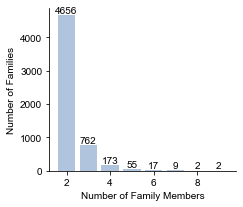

In [166]:
hist_df = count_fam.groupby("ptid").count().reset_index()\
.rename(columns={"ptid":"Number of Family Members","famid":"Number of Families"})

fig, ax = plt.subplots()
fig.set_size_inches(figsize_1colw,3)
bars = ax.bar( hist_df["Number of Family Members"], hist_df["Number of Families"],color="lightsteelblue", )

ax.bar_label(bars)
sns.despine()

plt.xlabel("Number of Family Members")
plt.ylabel("Number of Families")

save_and_track_figure(fig,"number_of_family_members.pdf")

17336
17336


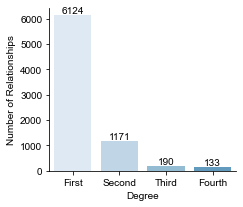

In [167]:
# Set the palette using the name of a palette:
sns.set_palette("Blues")

#Make sure there aren't duplicates because of demo

rel_only_df = rel_limit_df[["ptid","relation_mrn","rel_degree"]]
print( len(rel_limit_df) )

rel_only_df.drop_duplicates(inplace=True)
print( len(rel_only_df) )

#Count of individuals by degree, can be case OR control
degree_counts_all = rel_limit_df.groupby("rel_degree").agg({"mrn":'count'}).reset_index()

degree_counts = degree_counts_all[ degree_counts_all["rel_degree"].isin(["First","Second","Third","Fourth"]) ]
#degree_counts = degree_counts_all

#Divide by 2 since reciprical of every relationship is included
degree_counts["unique_rel_count"] = degree_counts["mrn"]/2
degree_counts.sort_values(by="unique_rel_count", ascending=False, inplace=True)

fig, ax = plt.subplots()
fig.set_size_inches(figsize_1colw,3)
sns.barplot(x="rel_degree", y="unique_rel_count", \
                 data=degree_counts)
sns.despine()

ax.set_xlabel("Degree")
ax.set_ylabel("Number of Relationships")
sns.despine()

ax.bar_label(ax.containers[0])

save_and_track_figure(fig,"relationship_degrees.pdf")

In [168]:
#Map hhid and bid to patients
rel_limit_df["hhid"] = rel_limit_df["ptid"].astype(int).map(mrn2hhid)
rel_limit_df["bid"] = rel_limit_df["ptid"].astype(int).map(mrn2bid)

rel_limit_df["rel_hhid"] = rel_limit_df["relation_mrn"].astype(int).map(mrn2hhid)
rel_limit_df["rel_bid"] = rel_limit_df["relation_mrn"].astype(int).map(mrn2bid)

In [169]:
#Percent relatives that share hhid (will be the same as bid overlap)
len( rel_limit_df[ rel_limit_df["hhid"] == rel_limit_df["rel_hhid"]]["ptid"].unique())\
/len(rel_limit_df["ptid"].unique())

0.5197226870666986

In [170]:
share_hhid_df = rel_limit_df[ (rel_limit_df['hhid'] == rel_limit_df['rel_hhid'] ) &\
            (rel_limit_df['mrn'] != rel_limit_df['relation_mrn'] )
            
            ]

In [171]:
#percent that live together

degree_hhid_list = list()
for degree in ["First","Second","Third","Fourth"]:
    
    shared_hhid_count = len( share_hhid_df[share_hhid_df["rel_degree"] == degree][["mrn","relation_mrn"]].drop_duplicates() )
    all_degree = len( rel_limit_df[rel_limit_df["rel_degree"] == degree][["mrn","relation_mrn"]].drop_duplicates() )
    
    percent_live_together = shared_hhid_count/all_degree
    #must divide by 2 since reciprical
    total_live_together = shared_hhid_count/2
    total_with_that_rel = all_degree/2
    
    degree_hhid_list.append([degree,total_live_together,total_with_that_rel,percent_live_together])
    

In [172]:
pd.DataFrame(degree_hhid_list,columns=["Degree","N Lives Together","N","Percent lives together"])

,Degree,N Lives Together,N,Percent lives together
0,First,3294.0,6124.0,0.537884
1,Second,255.0,1171.0,0.217763
2,Third,13.0,190.0,0.068421
3,Fourth,9.0,133.0,0.067669


In [173]:
#Percent relatives that share hhid
len( rel_limit_df[ rel_limit_df["bid"] == rel_limit_df["rel_bid"]]["ptid"].unique())\
/len(rel_limit_df["ptid"].unique())


0.5197226870666986

## Get age by week

In [174]:
mrn2age = dict( zip( demo_df["ptid"], demo_df["age"] ) )

In [175]:

regex = r'(\d+_\d+_\d+)'

pull_date = lambda trait_name: datetime.strptime(re.findall(regex, trait_name)[0]\
                                                 ,'%Y-%m-%d').date()

pull_date_window = lambda trait_name: datetime.strptime(re.findall(regex, trait_name)[0]\
                                                 ,'%m_%d_%Y').date()

In [176]:


directory = cummulative_directory  # directory of gzip cummulative files

# Get a list of all gzip files in the directory
gzip_files = [file for file in os.listdir(directory) if file.endswith('.gz')]

# # List to store the DataFrames

cases = dict()
controls = dict()


percent_female_list = []
# Iterate over each gzip file and read its contents into a DataFrame
for file_name in gzip_files:
#     print(file_name)
    file_path = os.path.join(directory, file_name)
    with gzip.open(file_path, 'rt') as file:
        df = pd.read_csv(file, delimiter='\t')  # Adjust the delimiter and other options as per your file format

        #Map familiy IDS
        df["famid"] = df["ptid"].map(mrn2famid)
        df["sex"] = df["ptid"].map(mrn2sex)
        
        
        #For every week, pull out cases and control IDs, and their ages
        for pheno in df["pheno"].unique():
            
            #Limit dataframe to those patients in solar run (ie for w/ proband has at least 1 case and 2 fam members)
            df_solar = pull_fam_count(pheno, df, print_res=False, return_patient_limited_df=True)
            
            week = pull_date_window(pheno)
            cases[week] = list(df_solar[ (df_solar["value"] == 1) ]["ptid"].map(mrn2age))
            controls[week] = list( df_solar[ (df_solar["value"] == 0) ]["ptid"].map(mrn2age))
            
         
            percent_female_list.append( (week, round( len( df_solar[ df_solar["sex"] == "F"] ) / len(df_solar) * 100 , 2)))


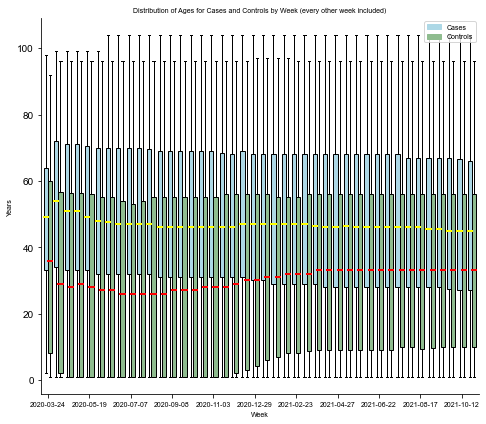

In [242]:
# Graph box and whisker plot of ages per week for cases and controls to see why it changes over time
weeks = list(cases.keys())[::2]  # Select every other week


sorted_weeks = sorted(weeks, key=lambda x: x if isinstance(x, datetime) \
                 else datetime(x.year, x.month, x.day))

case_ages = [cases[week] for week in sorted_weeks]
control_ages = [controls[week] for week in sorted_weeks]

# Create a new figure
fig = plt.figure(figsize=(figsize_2colw,6))

# Calculate the positions for box plots
case_positions = np.arange(len(sorted_weeks)) - 0.2
control_positions = np.arange(len(sorted_weeks)) + 0.2

# Create the box plot for cases
case_box = plt.boxplot(case_ages, positions=case_positions, widths=0.4, patch_artist=True, boxprops=dict(facecolor='lightblue'))

# Create the box plot for controls
control_box = plt.boxplot(control_ages, positions=control_positions, widths=0.4, patch_artist=True, boxprops=dict(facecolor='darkseagreen'))

# Customize the style of the median line
for box in case_box['medians']:
    box.set(color='yellow', linewidth=2)  # Change median line color and thickness

for box in control_box['medians']:
    box.set(color='red', linewidth=2)  # Change median line color and thickness

# Add x-axis labels and title with increased font size
plt.xlabel("Week", fontsize=7)
plt.ylabel("Years", fontsize=7)
plt.title("Distribution of Ages for Cases and Controls by Week (every other week included)", fontsize=7)

# Set x-axis tick labels with every 4th label
plt.xticks(range(0, len(weeks), 4), sorted_weeks[::4], fontsize=7)

# Create custom legend
cases_patch = mpatches.Patch(color='lightblue', label='Cases')
controls_patch = mpatches.Patch(color='darkseagreen', label='Controls')
plt.legend(handles=[cases_patch, controls_patch], fontsize=7, loc='upper right')


# Remove top and right borders
sns.despine()

plt.tight_layout()

# Save the figure using fig instead of plt
save_and_track_figure(fig, "age_dist.pdf")

In [244]:
#sample size

len( case_ages[-1] ) + len( control_ages[-1] )

3174